In [89]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
# import sklearn
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# import tensorflow as tf


In [116]:
tf.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [90]:
df=pd.read_csv('/Users/taliyas/Downloads/brain_stroke.csv')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [91]:
print("df shape: ", df.shape)
df.isnull().sum()

df shape:  (4981, 11)


gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [92]:
# Encode features into numerics

df['gender'] = df['gender'].map({'Female':1,'Male':0})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job':2, 'children':3})
df['Residence_type'] = df['Residence_type'].map({'Urban': 1, 'Rural':0})
df['smoking_status'] = df['smoking_status'].map({'formerly smoked':0, 'never smoked':1, 'smokes':2, 'Unknown':3})


In [93]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,0,1
1,0,80.0,0,1,1,0,0,105.92,32.5,1,1
2,1,49.0,0,0,1,0,1,171.23,34.4,2,1
3,1,79.0,1,0,1,1,0,174.12,24.0,1,1
4,0,81.0,0,0,1,0,1,186.21,29.0,0,1


In [94]:
from sklearn.preprocessing import MinMaxScaler

In [98]:
tf.random.set_random_seed(22)
# tf.random.set_seed(22)

In [99]:
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,0,1,228.69,36.6,0,1
1,0,80.0,0,1,1,0,0,105.92,32.5,1,1
2,1,49.0,0,0,1,0,1,171.23,34.4,2,1
3,1,79.0,1,0,1,1,0,174.12,24.0,1,1
4,0,81.0,0,0,1,0,1,186.21,29.0,0,1
5,0,74.0,1,1,1,0,0,70.09,27.4,1,1
6,1,69.0,0,0,0,0,1,94.39,22.8,1,1
7,1,78.0,0,0,1,0,1,58.57,24.2,3,1
8,1,81.0,1,0,1,0,0,80.43,29.7,1,1
9,1,61.0,0,1,1,2,0,120.46,36.8,2,1


In [100]:
train_dataset = df.sample(frac=0.75, random_state=1)
train_dataset.shape

(3736, 11)

In [101]:
test_dataset = df.drop(train_dataset.index)
test_dataset.shape

(1245, 11)

In [102]:
x_train, y_train = train_dataset.iloc[:,:-1], train_dataset.iloc[:,-1:]
x_test, y_test = test_dataset.iloc[:,:-1], test_dataset.iloc[:,-1:]

In [103]:
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

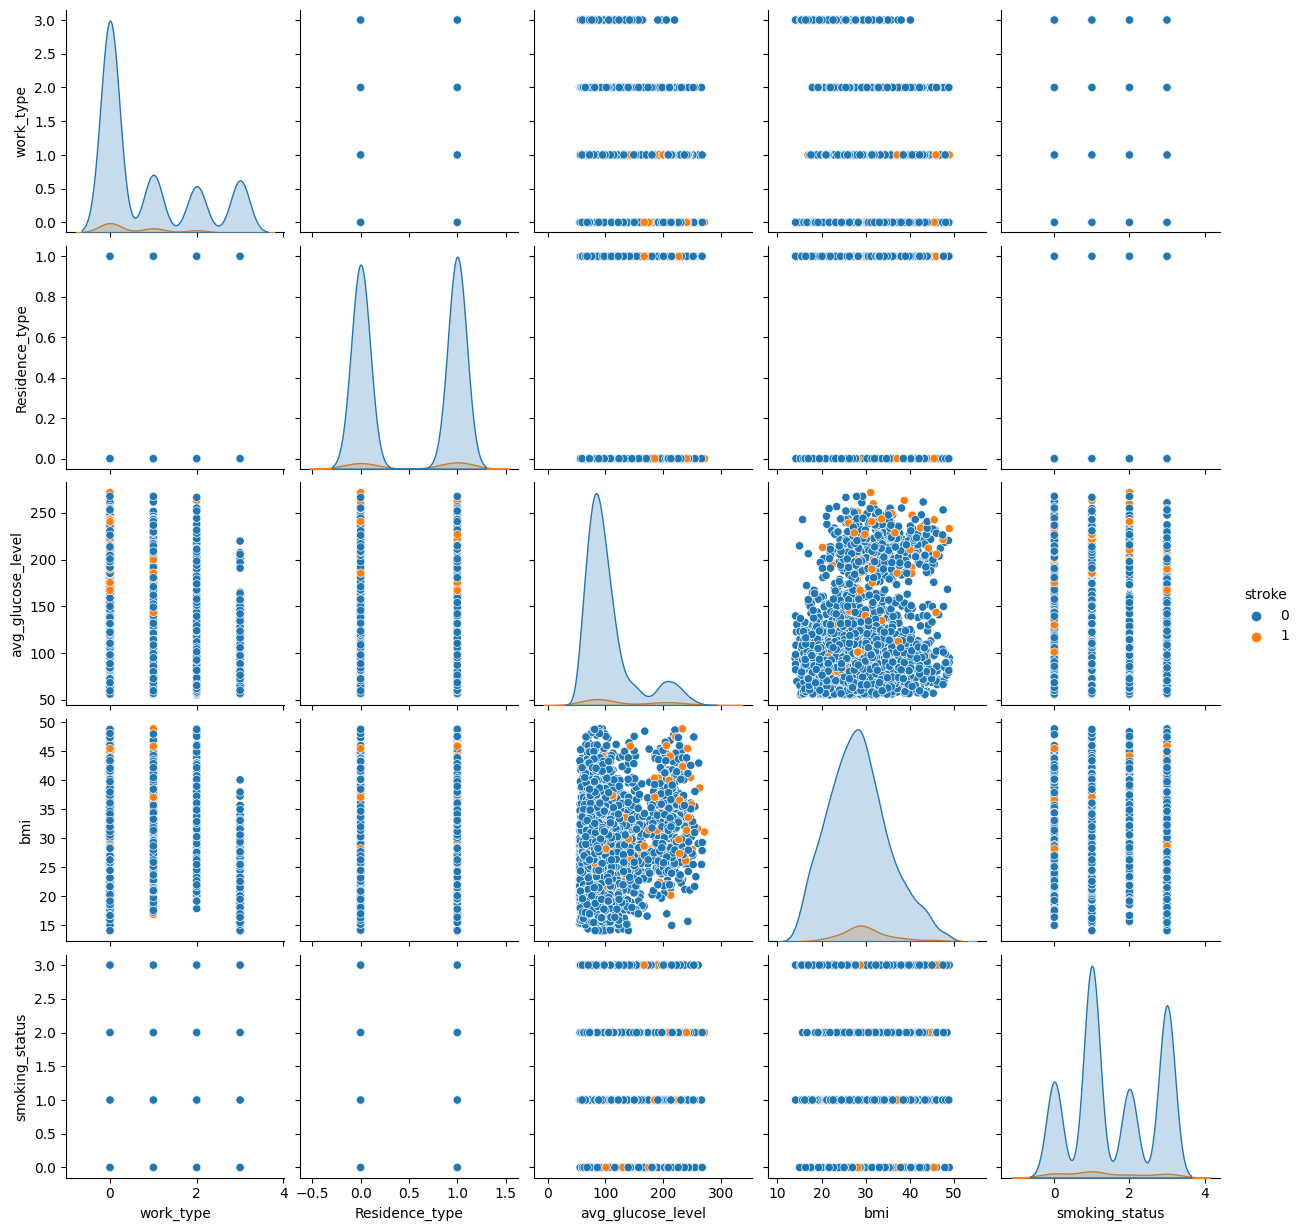

In [75]:
import seaborn as sns
sns.pairplot(train_dataset.iloc[:,5:11], hue = "stroke", diag_kind='kde');

In [104]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)


In [105]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

In [106]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False

  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

In [108]:

log_reg = LogisticRegression()
y_pred = log_reg(x_train_norm[:5], train=False)



In [109]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

In [111]:
# tf.compat.v1.enable_eager_execution()
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

In [115]:
tf.executing_eagerly()

False

In [114]:
tf.enable_eager_execution()

ValueError: tf.enable_eager_execution must be called at program startup.

In [112]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for  x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.